In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
from prettytable import PrettyTable
from datetime import datetime, date

In [2]:
url = 'https://www.mohfw.gov.in/'

# make a GET request to fetch the raw HTML content
web_content = requests.get(url).content

# parse the html content
soup = BeautifulSoup(web_content, "html.parser")

# remove any newlines and extra spaces from left and right
extract_contents = lambda row: [x.text.replace('\n', '') for x in row]

# find all table rows and data cells within
stats = [] 
all_rows = soup.find_all('tr')

for row in all_rows:
    stat = extract_contents(row.find_all('td'))    
# the data that we require is a list of length 5
    if len(stat) == 5:
        stats.append(stat)
        
#now convert the data into a pandas dataframe for further processing
new_cols = ["Sr.No", "States/UT","Confirmed","Recovered","Deceased"]
state_data = pd.DataFrame(data = stats, columns = new_cols)
state_data.head()

,Sr.No,States/UT,Confirmed,Recovered,Deceased
0,1,Andhra Pradesh,348,6,4
1,2,Andaman and Nicobar Islands,11,0,0
2,3,Arunachal Pradesh,1,0,0
3,4,Assam,29,0,0
4,5,Bihar,39,0,1


In [3]:
state_data['Confirmed'] = state_data['Confirmed'].map(int)
state_data['Recovered'] = state_data['Recovered'].map(int)
state_data['Deceased'] = state_data['Deceased'].map(int)
state_data['Date'] = date.today()

In [4]:
table = PrettyTable()
table.field_names = (new_cols)

for i in stats:
    table.add_row(i)
    
table.add_row(["","Total", sum(state_data['Confirmed']), sum(state_data['Recovered']), sum(state_data['Deceased'])])
               
print(table)

+-------+-----------------------------+-----------+-----------+----------+
| Sr.No |          States/UT          | Confirmed | Recovered | Deceased |
+-------+-----------------------------+-----------+-----------+----------+
|   1   |        Andhra Pradesh       |    348    |     6     |    4     |
|   2   | Andaman and Nicobar Islands |     11    |     0     |    0     |
|   3   |      Arunachal Pradesh      |     1     |     0     |    0     |
|   4   |            Assam            |     28    |     0     |    0     |
|   5   |            Bihar            |     39    |     0     |    1     |
|   6   |          Chandigarh         |     18    |     7     |    0     |
|   7   |         Chhattisgarh        |     10    |     9     |    0     |
|   8   |            Delhi            |    669    |     21    |    9     |
|   9   |             Goa             |     7     |     0     |    0     |
|   10  |           Gujarat           |    179    |     25    |    16    |
|   11  |           Harya

In [5]:
filename = "data_"+str(date.today())+".csv"
state_data.to_csv(os.path.join('data_IN',filename))

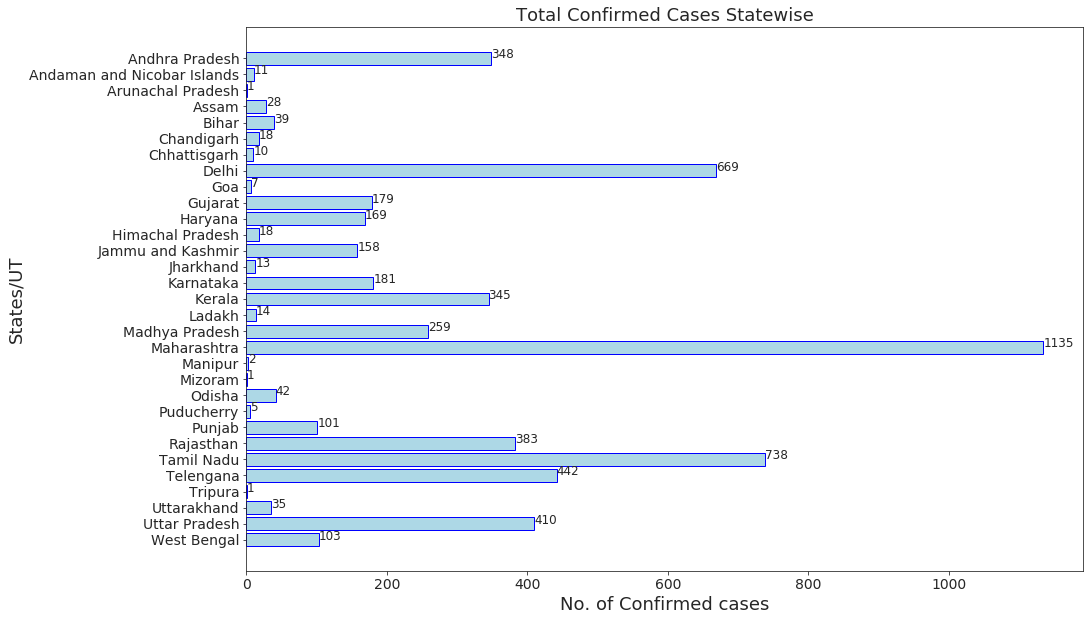

In [6]:
sns.set_style("ticks")
plt.figure(figsize = (15,10))

plt.barh(state_data["States/UT"], 
         state_data["Confirmed"].map(int),
         align = 'center', color = 'lightblue', edgecolor = 'blue')

plt.xlabel('No. of Confirmed cases', fontsize = 18)
plt.ylabel('States/UT', fontsize = 18)
plt.gca().invert_yaxis()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Total Confirmed Cases Statewise', fontsize = 18 )

for index, value in enumerate(state_data["Confirmed"]):
    plt.text(value, index, str(value), fontsize = 12)
    
plt.show()

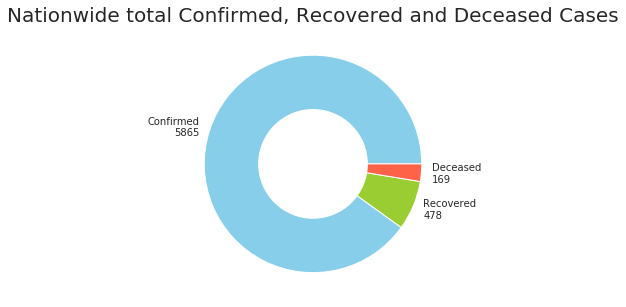

In [7]:
group_size = [sum(state_data['Confirmed']),
              sum(state_data['Recovered']),
              sum(state_data['Deceased'])]

group_labels = ['Confirmed\n' + str(sum(state_data['Confirmed'])),
                'Recovered\n' + str(sum(state_data['Recovered'])),
                'Deceased\n' + str(sum(state_data['Deceased']))]

custom_colors = ['skyblue','yellowgreen','tomato']

plt.figure(figsize = (5,5))
plt.pie(group_size, labels = group_labels, colors = custom_colors)
central_circle = plt.Circle((0,0), 0.5, color = 'white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size = 12)
plt.title('Nationwide total Confirmed, Recovered and Deceased Cases', fontsize = 20)

plt.show()

In [8]:
# reading the shape file of map of India in GeoDataFrame

map_data = gpd.read_file('Indian_States.shp')
map_data.rename(columns = {'st_nm':'States/UT'}, inplace = True)
map_data.head()

,States/UT,geometry
0,Andaman & Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432..."
2,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26..."
3,Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24..."
4,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623..."


In [9]:
map_data['States/UT'] = map_data['States/UT'].str.replace('&','and')
map_data['States/UT'].replace('Arunanchal Pradesh',
                              'Arunachal Pradesh', inplace = True)
map_data['States/UT'].replace('Telangana', 
                              'Telengana', inplace = True)
map_data['States/UT'].replace('NCT of Delhi', 
                              'Delhi', inplace = True)
map_data['States/UT'].replace('Andaman and Nicobar Island', 
                              'Andaman and Nicobar Islands', 
                               inplace = True)

In [10]:
merged_data = pd.merge(map_data, state_data, 
                       how = 'left', on = 'States/UT')

merged_data.fillna(0, inplace = True)
merged_data.drop('Sr.No', axis = 1, inplace = True)
merged_data.head()

,States/UT,geometry,Confirmed,Recovered,Deceased,Date
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",11.0,0.0,0.0,2020-04-10
1,Arunachal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432...",1.0,0.0,0.0,2020-04-10
2,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...",28.0,0.0,0.0,2020-04-10
3,Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...",39.0,0.0,1.0,2020-04-10
4,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",18.0,7.0,0.0,2020-04-10


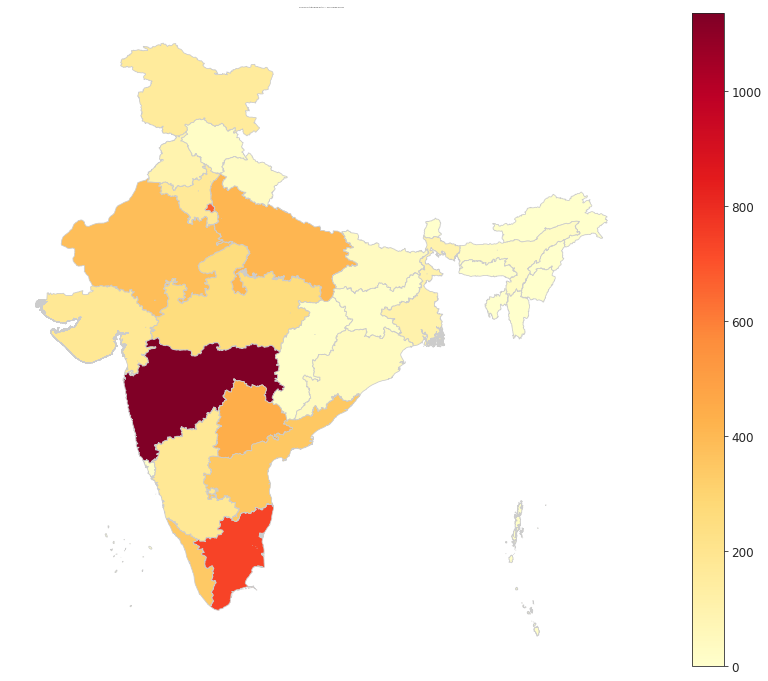

In [11]:
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')

ax.set_title('Covid-19 Statewise Data — Confirmed Cases', 
             fontdict =  {'fontsize': '2', 'fontweight' : '3'})

merged_data.plot(column = 'Confirmed', cmap='YlOrRd', 
                 linewidth=0.8, ax=ax, edgecolor='0.8', 
                 legend = True)
plt.show()